In [214]:
# get image.
!wget https://miro.medium.com/max/1024/1*lKz4iFqzz2vt04k21YWuUw.jpeg -O sample.jpg

--2020-04-27 14:39:55--  https://miro.medium.com/max/1024/1*lKz4iFqzz2vt04k21YWuUw.jpeg
Resolving miro.medium.com (miro.medium.com)... 104.16.117.145, 104.16.120.145, 104.16.119.145, ...
Connecting to miro.medium.com (miro.medium.com)|104.16.117.145|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 64566 (63K) [image/jpeg]
Saving to: ‘sample.jpg’

sample.jpg          100%[===================>]  63.05K  --.-KB/s    in 0.006s  

2020-04-27 14:39:55 (9.48 MB/s) - ‘sample.jpg’ saved [64566/64566]



<img src='sample.jpg' width=200>

In [215]:
import imageio
import numpy as np
import networkx as nx
from skimage import filters

import time

import matplotlib.pyplot as plt
%matplotlib inline

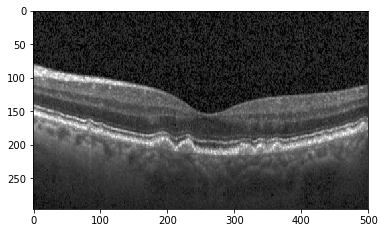

In [216]:
# read 1 channel from jpeg
org_img = imageio.imread('sample.jpg')
# crop
img = np.array(org_img)[100:-100,:500,0]

plt.imshow(img,cmap='gray')

compute weights 0.16228747367858887
construct graph 3.8521416187286377
find path 3.419970989227295
7.574464559555054


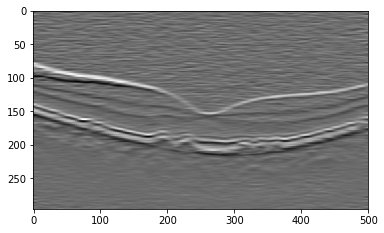

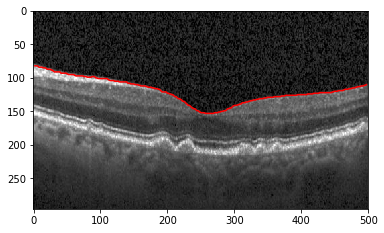

In [217]:


# copy of np.isin method
def isin(element, test_elements, assume_unique=False, invert=False):
    "..."
    element = np.asarray(element)
    return np.in1d(element, test_elements, assume_unique=assume_unique,
                invert=invert).reshape(element.shape)

def get_adjacency_matrix(img,ulim=None,llim=None,epsilon=1e-5):
    # construct adjacency matrix later used to create a sparse graph per Chiu et al.
    # https://www.mathworks.com/matlabcentral/fileexchange/43518-graph-based-segmentation-of-retinal-layers-in-oct-images
    # https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3342188/

    adjMAsub = np.array(np.arange(0,len(img.ravel())))
    adjMAx,adjMAy = np.unravel_index(adjMAsub,img.shape)

    adjMAsub = np.expand_dims(adjMAsub,axis=-1)
    adjMAx = np.expand_dims(adjMAx,axis=-1)
    adjMAy = np.expand_dims(adjMAy,axis=-1)
    
    neighborIterX = np.array([[1, 1, 1, 0, 0, -1, -1 ,-1]])
    neighborIterY = np.array([[1, 0, -1, 1, -1,  1,  0, -1]])
    neighborIterX = np.repeat(neighborIterX, adjMAsub.shape[0], axis=0)
    neighborIterY = np.repeat(neighborIterY, adjMAsub.shape[0], axis=0)
    
    adjMAsub = np.repeat(adjMAsub, 8, axis=1)
    adjMAx = np.repeat(adjMAx, 8, axis=1)
    adjMAy = np.repeat(adjMAy, 8, axis=1)
    
    adjMBx = adjMAx + neighborIterX
    adjMBy = adjMAy + neighborIterY
    
    adjMAsub = adjMAsub.ravel()
    adjMAx = adjMAx.ravel()
    adjMAy = adjMAy.ravel()
    
    adjMBx = adjMBx.ravel()
    adjMBy = adjMBy.ravel()

    criteria = np.array([
        [adjMBx > 0],
        [adjMBx < img.shape[0]],
        [adjMBy > 0],
        [adjMBy < img.shape[1]],
    ])
    
    keepInd = np.all(criteria,axis=0).squeeze()
        
    adjMAsub = adjMAsub[keepInd==1]
    adjMAx = adjMAx[keepInd==1]
    adjMAy = adjMAy[keepInd==1]
    
    adjMBx = adjMBx[keepInd==1]
    adjMBy = adjMBy[keepInd==1]
    adjMBsub = np.ravel_multi_index([adjMBx,adjMBy], img.shape) 
    
    adjMW = 2 - img.ravel()[adjMAsub] - img.ravel()[adjMBsub] + epsilon;
    
    # make both sides low weight
    mask = np.zeros(img.shape)
    mask[:,0]=1
    mask[:,-1]=1
    side_x, side_y = np.where(mask==1)
    side_ind = np.ravel_multi_index([side_x, side_y],img.shape)
    isonsideA = isin(adjMAsub, side_ind)
    adjMW[isonsideA==1]=epsilon #super low weight to force node to be selected as part of path
    
    # limit path to a slab based on llim and ulim
    if llim is not None:
        nogo = np.zeros(img.shape)
        nogo[llim:,2:img.shape[1]-2]=1
        nogo_x, nogo_y = np.where(nogo==1)
        nogo_ind = np.ravel_multi_index([nogo_x, nogo_y],img.shape)
        isnogoA = isin(adjMAsub, nogo_ind)        
        adjMW[isnogoA==1]=2 #high weight to prevent node to be select as part of path.
        
    if ulim is not None:
        nogo = np.zeros(img.shape)
        nogo[:ulim,2:img.shape[1]-2]=1
        nogo_x, nogo_y = np.where(nogo==1)
        nogo_ind = np.ravel_multi_index([nogo_x, nogo_y],img.shape)
        isnogoA = isin(adjMAsub, nogo_ind)        
        adjMW[isnogoA==1]=2 #high weight to prevent node to be select as part of path.
        
    edge_weights = np.array([adjMAsub,adjMBsub,adjMW])
    return edge_weights, adjMAsub,adjMBsub
    
    
def segment_layer(pimg,dark2bright=True,ulim=None,llim=None):
    
    pimg = pimg.astype(np.float)
    # blur - more smooth in horizontal direction
    pimg = filters.gaussian(pimg, sigma=(0.5,3))
    
    # get gradient image
    gradx,grady = np.gradient(pimg,1)
    if dark2bright:
        pass
    else:
        gradx*=-1
        
    gradx = (gradx-np.min(gradx))/(np.max(gradx)-np.min(gradx))

    stime = time.time()
    
    # construct edge weights with gradient image
    edge_weights, adjMAsub,adjMBsub = get_adjacency_matrix(gradx,ulim=ulim,llim=llim)
    
    etime = time.time()
    print('compute weights',etime-stime)
    
    stime = time.time()
    # build graph
    FG=nx.Graph()
    FG.add_weighted_edges_from(edge_weights.T)
    
    etime = time.time()
    print('construct graph',etime-stime)
    
    # declare start and end points
    start_coord = (0,0)
    end_coord = tuple(np.array(gradx.shape)-1)
    
    selected_inds = np.ravel_multi_index(np.array([start_coord,end_coord]).T,gradx.shape)
    start_ind,end_ind=tuple(selected_inds)
    
    stime = time.time()
    # get shortest path between 2 points
    sp = nx.shortest_path(FG,source=start_ind,target=end_ind,weight='weight')
    sp_x, sp_y = np.unravel_index(np.array(sp).astype(int),gradx.shape)
    
    etime = time.time()
    print('find path',etime-stime)
    
    # trim the path ( dont care about path at both sides of image)
    keeps = np.logical_and(sp_y>1,sp_y<gradx.shape[1]-2)
    sp_x = sp_x[keeps]
    sp_y = sp_y[keeps]
    sp = np.array(sp).astype(int)[keeps]
    
    return sp_x,sp_y,sp

bimg = filters.gaussian(img, sigma=(0.5,3))
gradx,grady = np.gradient(pimg,1)
plt.figure(0)
plt.imshow(gradx,cmap='gray')

stime = time.time()
indx,indy,inds = segment_layer(img)
etime = time.time()
print(etime-stime)

plt.figure(1)
plt.imshow(img,cmap='gray')
plt.plot(indy,indx,color='red')

compute weights 0.1846632957458496
construct graph 4.413400411605835
find path 3.297555923461914


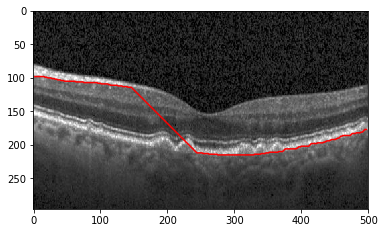

In [218]:
indx,indy,inds = segment_layer(pimg,dark2bright=False)

plt.imshow(img,cmap='gray')
plt.plot(indy,indx,color='red')

compute weights 0.3139462471008301
construct graph 4.443150281906128
find path 2.527416706085205


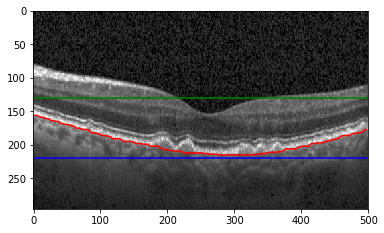

In [219]:
# top layer (NFL) too bright, limit search zone
ulim,llim=130,220
indx,indy,inds = segment_layer(pimg,dark2bright=False,ulim=ulim,llim=llim)

plt.imshow(img,cmap='gray')
plt.plot(indy,indx,color='red')

plt.axhline(ulim,color='green')
plt.axhline(llim,color='blue')